In [89]:
import numpy as np
import osqp
import matplotlib.pyplot as plt
from scipy import sparse
import control as ct
from casadi import *
import dpilqr
import itertools
import cvxpy as cp

In [90]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
from solvers.util import (
    compute_pairwise_distance,
    compute_pairwise_distance_nd_Sym,
    define_inter_graph_threshold,
    distance_to_goal,
    split_graph, 
    generate_f,
    generate_f_human_drone,
    objective,
    generate_min_max_input,
    generate_min_max_state
)


In [92]:
def linear_kinodynamics(dt,n_agent):
    #Decision vector is a = [a_x, a_y, a_z]
    #State vector is X = [p_x, p_y, p_z, v_x, v_y, v_z]
    #Discretization time step is dt
    A_tot = sparse.lil_matrix((6*n_agent, 6*n_agent))
    B_tot = sparse.lil_matrix((6*n_agent, 3*n_agent))
    A = sparse.csc_matrix([[1, 0, 0, dt, 0, 0],
                           [0, 1, 0, 0 , dt ,0],\
                           [0, 0, 1, 0, 0 , dt],\
                           [0, 0, 0, 1, 0 ,0],\
                           [0, 0, 0, 0, 1 ,0],\
                           [0, 0, 0, 0, 0, 1]])
    B = sparse.csc_matrix([[dt**2/2, 0, 0],\
                           [0, dt**2/2, 0],\
                           [0, 0, dt**2/2],\
                           [dt, 0, 0 ],\
                           [0, dt , 0],\
                           [0, 0, dt]])

    for i in range(n_agent):
        A_tot[i*6:(i+1)*6,i*6:(i+1)*6] = A
        B_tot[i*6:(i+1)*6,i*3:(i+1)*3] = B
        
    
    return A_tot, B_tot
        
        
    

In [93]:
from solvers import util

## Solving the consensus ADMM problem with OSQP

In [94]:
import cvxpy as cp

In [95]:
def compute_pairwise_distance_CVX(X, x_dims, n_dims):
    """Analog to the above whenever some agents only use distance in the x-y plane"""
    CYLiER_RADIUS = 0.2

    n_states = x_dims[0]
    n_agents = len(x_dims)
    distances = []
    eps = 1e-3

    for i, n_dim_i in zip(range(n_agents), n_dims):
        for j, n_dim_j in zip(range(i + 1, n_agents), n_dims[i + 1 :]):
            n_dim = min(n_dim_i, n_dim_j)

            Xi = X[i * n_states : i * n_states + n_dim]
            Xj = X[j * n_states : j * n_states + n_dim]
            dX = Xi-Xj

            if n_dim == 3:
                # distances.append(cp.sqrt(dX[0]**2+dX[1]**2+dX[2]**2+eps))
                distances.append(cp.norm(dX))
            else:
                distances.append(cp.sqrt(dX[0]**2+dX[1]**2 + eps)+CYLiER_RADIUS)
    
    return distances

In [96]:
# Solving a MPC problem with OSQP solver at each iteration
N = 15

cost = 0
constr = []
x0,xr = util.paper_setup_3_quads()

radius = 0.3
n_agents = 3
nx = n_agents * 6
nu = n_agents * 3
X_full = np.zeros((0,nx))
X_full = np.r_[X_full,x0.reshape(1,-1)]

U_full = np.zeros((0,nu))

xi = x0.flatten()
xr = xr.flatten()
Ad,Bd = linear_kinodynamics(0.1, n_agents)

Q = sparse.diags([5., 5., 5., 1., 1., 1.]*n_agents)
QN = Q*500
R = 0.1*sparse.eye(nu)
n_states = 6
n_inputs = 3
iter = 0
x_dims = [n_states]*n_agents
n_dims = [3]*n_agents
obj_val = []
while not np.all(dpilqr.distance_to_goal(xi,xr,n_agents,6,3) < 0.1) and (iter <= 150):
# for _ in range(50):
    x = cp.Variable((N+1,nx))
    u = cp.Variable((N,nu))
    cost = 0
    constr = []

    for t in range(N):

        cost += cp.quad_form(x[t,:]-xr.flatten(),Q) + cp.quad_form(u[t,:],R)
        constr += [x[t + 1,:] == Ad @ x[t,:] + Bd @ u[t, :]]
        constr += [u[t,:] <= np.tile(np.array([3, 3, 3]),(n_agents,)) ]
        constr += [np.tile(np.array([-3, -3, -3]),(n_agents,)) <= u[t, :]]
        # constr += [x[t, :] <= np.tile(np.array([5, 5, 5, 3, 3, 3]),(n_agents,))]
        # constr += [np.tile(-np.array([-5, -5, -5, -3, -3, -3]),(n_agents,)) <= x[t,:]]
                    
        # Linearized collision avoidance constraints
        if iter > 0:
            x_prev = X_full[iter-1]
            # print(f'x_prev has shape {x_prev.shape}')
            for i in range(n_agents):
                for j in range(n_agents):
                    if j != i:
                        #See "Generation of collision-free trajectories for a quadrocopter fleet: 
                        # A sequential convex programming approach" for the linearization step;
                        constr += [cp.norm(x_prev[j*n_states:j*n_states+3]-  \
                                           x_prev[i*n_states:i*n_states+3]) + \
                                (x_prev[j*n_states:j*n_states+3].T- \
                                 x_prev[i*n_states:i*n_states+3].T)/cp.norm(x_prev[j*n_states:j*n_states+3] \
                                -x_prev[i*n_states:i*n_states+3])@ \
                                   ((x[t,j*n_states:j*n_states+3]-x[t,i*n_states:i*n_states+3])- \
                                    (x_prev[j*n_states:j*n_states+3]-x_prev[i*n_states:i*n_states+3])) >= radius]

    cost += cp.quad_form((x[-1,:]-xr.flatten()),QN)    

    constr += [x[0, :] == xi]

    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(verbose=True, warm_start = True)
    
    obj_val.append(problem.objective.value)

    u_trj = u.value
    x_trj = x.value
    ctrl = u_trj[1]
    xi = Ad@xi + Bd@ctrl
    X_full = np.r_[X_full,xi.reshape(1,-1)]
    U_full = np.r_[U_full, ctrl.reshape(1,-1)]

    iter +=1



                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jun 20 06:55:00 AM: Your problem has 423 variables, 46 constraints, and 0 parameters.
(CVXPY) Jun 20 06:55:00 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 20 06:55:00 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 20 06:55:00 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 20 06:55:00 AM: Compiling problem (target solver=OSQP).
(CVXPY) Jun 20 06:55:00 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffi

In [88]:
# Solving a MPC problem with OSQP solver at each iteration w/ augmented state variable
N = 15

cost = 0
constr = []
x0,xr = util.paper_setup_3_quads()

radius = 0.3
n_agents = 3
nx = n_agents * 6
nu = n_agents * 3
X_full = np.zeros((0,nx))
X_full = np.r_[X_full,x0.reshape(1,-1)]

U_full = np.zeros((0,nu))

xi = x0.flatten()
xr = xr.flatten()
Ad,Bd = linear_kinodynamics(0.1, n_agents)

Q = sparse.diags([5., 5., 5., 1., 1., 1.]*n_agents)
QN = Q*500
R = 0.1*sparse.eye(nu)
n_states = 6
n_inputs = 3
iter = 0
x_dims = [n_states]*n_agents
n_dims = [3]*n_agents
obj_val = []
while not np.all(dpilqr.distance_to_goal(xi,xr,n_agents,6,3) < 0.1) and (iter <= 150):
# for _ in range(50):
    y_state = cp.Variable((((N+1)*nx + N * nu, 1)))
    cost = 0
    constr = []
    
    # for t in range(N-1):
    #     cost += cp.quad_form(u[t+1,:]-u[t,:], np.eye(nu)) #control variation penalty

    for t in range(N):

        cost += cp.quad_form(cp.reshape(y_state[0:(N+1)*nx],[N+1, nx])[t,:]-xr.flatten(),Q) + \
        cp.quad_form(cp.reshape(y_state[(N+1)*nx:], [N, nu])[t,:],R)

        constr += [cp.reshape(y_state[:(N+1)*nx], [N+1, nx])[t+1,:] \
                            == Ad @ cp.reshape(y_state[:(N+1)*nx], [N+1, nx])[t] \
                                + Bd @ cp.reshape(y_state[(N+1)*nx:], [N, nu])[t]]  
        constr += [cp.reshape(y_state[(N+1)*nx:], [N, nu])[t]<= np.tile(np.array([3, 3, 3]),(n_agents,))]
        constr += [np.tile(np.array([-3, -3, -3]),(n_agents,)) <= cp.reshape(y_state[(N+1)*nx:], [N, nu])[t]]
                    
        # Linearized collision avoidance constraints
        if iter > 0:
            x_prev = X_full[iter-1]
            # print(f'x_prev has shape {x_prev.shape}')
            for i in range(n_agents):
                for j in range(n_agents):
                    if j != i:
                        #See "Generation of collision-free trajectories for a quadrocopter fleet: 
                        # A sequential convex programming approach" for the linearization step;
                        constr += [cp.norm(x_prev[j*n_states:j*n_states+3]-  \
                                x_prev[i*n_states:i*n_states+3]) + \
                                (x_prev[j*n_states:j*n_states+3].T- \
                                    x_prev[i*n_states:i*n_states+3].T)/cp.norm(x_prev[j*n_states:j*n_states+3] \
                                -x_prev[i*n_states:i*n_states+3])@  \
                                ((cp.reshape(y_state[:(N+1)*nx],[N+1,nx])[t][j*n_states:j*n_states+3] \
                                -cp.reshape(y_state[:(N+1)*nx],[N+1,nx])[t][i*n_states:i*n_states+3])- \
                                (x_prev[j*n_states:j*n_states+3]- \
                                    x_prev[i*n_states:i*n_states+3]).flatten()) >= radius]

    cost += cp.quad_form((cp.reshape(y_state[0:(N+1)*nx],[N+1, nx])[-1,:]-xr.flatten()),QN)   

    constr += [y_state[0:nx] == xi.reshape(1,-1)]

    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(verbose=True, warm_start = True)
    
    obj_val.append(problem.objective.value)

    u_trj = y_state.value[(N+1)*nx:].reshape((N, nu))
    x_trj = y_state.value[:(N+1)*nx].reshape((N+1, nx))
    ctrl = u_trj[1]
    xi = Ad@xi + Bd@ctrl
    X_full = np.r_[X_full,xi.reshape(1,-1)]
    U_full = np.r_[U_full, ctrl.reshape(1,-1)]

    iter +=1


                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jun 19 10:11:44 PM: Your problem has 423 variables, 46 constraints, and 0 parameters.
(CVXPY) Jun 19 10:11:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 19 10:11:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 19 10:11:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 19 10:11:44 PM: Compiling problem (target solver=OSQP).
(CVXPY) Jun 19 10:11:44 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffi

TypeError: 'NoneType' object is not subscriptable

In [85]:
y_state

Variable((423, 1))

In [79]:
np.tile(np.array([3, 3, 3]),(N,)).shape

(45,)

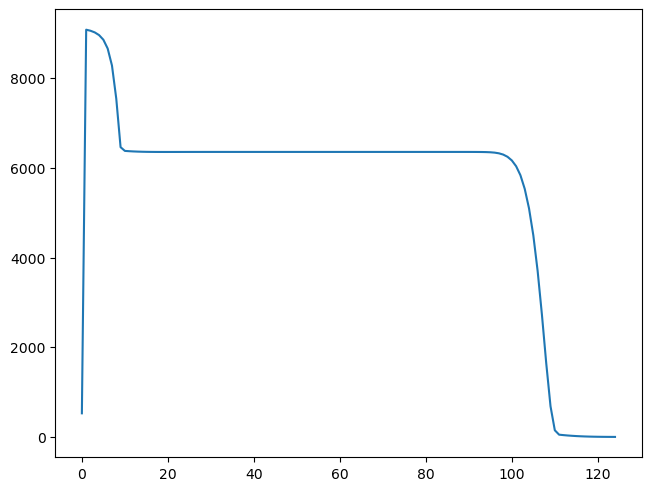

In [97]:
plt.figure();
plt.plot(obj_val);

In [98]:
obj_val[-1]

0.8480119742491704

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


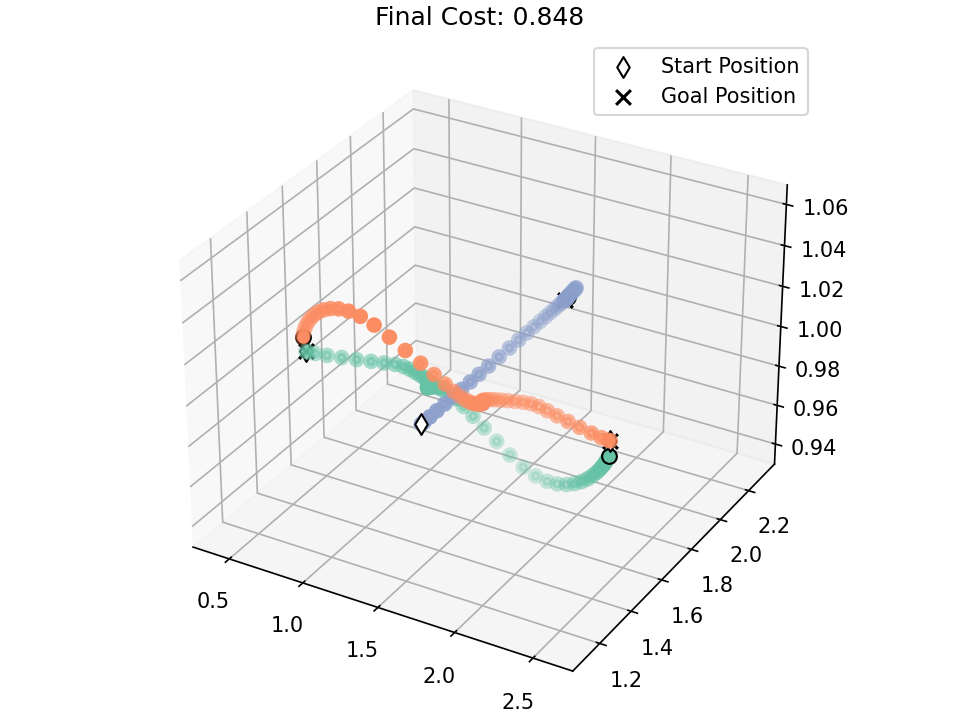

In [101]:
%matplotlib ipympl
plt.figure(dpi=150)
dpilqr.plot_solve(X_full,obj_val[-1],xr,[6,6,6],True,3)
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
plt.savefig('MPC_with_OSQP.png')

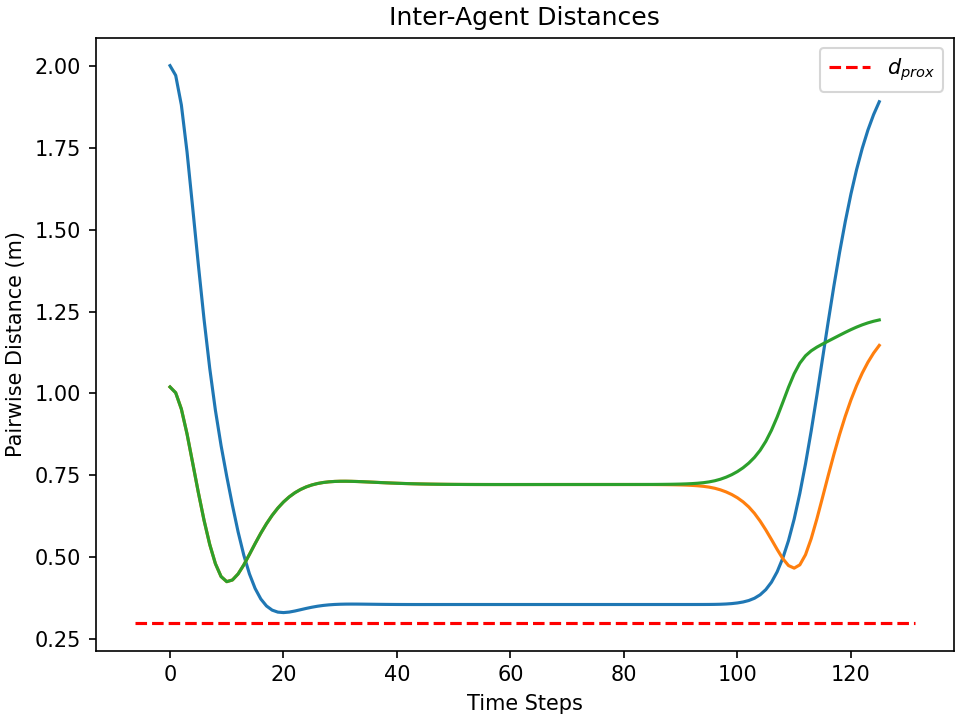

In [100]:
plt.figure(dpi=150)
dpilqr.plot_pairwise_distances(X_full, [6,6,6], [3,3,3], 0.3)
plt.savefig('QP_pairwise_distance.png')

#### We can't really run MPC with QP over a single fixed horizon because linearization of collision constraints is not possible -> we need a "previous solution" to linearize against

### Consensus-ADMM MPC w/ Qp

In [102]:
from solvers import util
from multiprocessing import Process, Pipe
import cvxpy as cp
# from multi_agent_scp import *

In [103]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
class AdmmMPC:
    def __init__(self, nx, nu, x0, xr, T, Q, R, Qf, N, Ad, Bd, radius = 0.3, MAX_ITER=10):
        self.nx = nx #Total No. of states
        self.nu = nu #Total No. of inputs
        self.xr = xr #Final cond.
        self.x0 = x0 #Initial cond.
        self.N = N #No. of agents
        self.T = T #Horizon
        # self.y_state = cp.Variable((((self.T+1)*self.nx + self.T * self.nu, 1)))
        self.Q = Q #Positive definite
        self.R = R #Positive definite ..
        self.Qf = Qf #Positive definite
        self.radius = radius #Collision threshold radius
        self.Ad = Ad #State matrix
        self.Bd = Bd #Input matrix
        self.MAX_ITER = MAX_ITER
        
        
    def objective_admm(self):
    
        """Compact form of quadratic tracking cost"""
        """y_aug: (x(0),x(1),...,x(N),u(0),...,u(N-1))"""
        # y_aug = y_state

#         objective = 0
#         # Quadratic objective
#         P = sparse.block_diag([sparse.kron(sparse.eye(self.T), self.Q), self.Qf,
#                            sparse.kron(sparse.eye(self.T), self.R)], format='csc')
#         # linear objective
#         q = np.hstack([np.kron(np.ones(self.T), -self.Q@self.xr.flatten()), -self.Qf@self.xr.flatten(), np.zeros(self.T*self.nu)])
#         objective += 1/2 * cp.quad_form(y_state, P) + q.T @ y_state #Quadratic tracking cost
        self.y_state = cp.Variable((((self.T+1)*self.nx + self.T * self.nu, 1)))
        cost = 0
        # x_trj_var = cp.reshape(y_state[0:(self.T+1)*self.nx],[self.T+1, self.nx])
        # u_trj_var = cp.reshape(y_state[(self.T+1)*self.nx:], [self.T, self.nu])
        
        for t in range(N):
            
            cost += cp.quad_form(cp.reshape(self.y_state[0:(self.T+1)*self.nx],[self.T+1, self.nx])[t,:]-xr.flatten(),self.Q) + \
            cp.quad_form(cp.reshape(self.y_state[(self.T+1)*self.nx:], [self.T, self.nu])[t,:],self.R)
        
        cost += cp.quad_form((cp.reshape(self.y_state[0:(self.T+1)*self.nx],[self.T+1, self.nx])[-1,:]-xr.flatten()),self.Qf)    
 
        return cost
        

    def construct_obj_i(self):
        f_list = []
        for id in range(N):
            cost_i = self.objective_admm() #Objective of each augmented sub-system
                                           #Global variable consensus optimziation
            f_list.append(cost_i)

        return f_list 
    
    
    def run_worker(self, f, pipe):
        n_states = 6
        xbar = cp.Parameter((self.T+1)*self.nx + self.T*self.nu, value=np.zeros((self.T+1)*self.nx + self.T*self.nu))
        u = cp.Parameter((self.T+1)*self.nx + self.T*self.nu, value=np.zeros((self.T+1)*self.nx + self.T*self.nu)) 
        #This is the scaled Lagrange multiplier

        rho = 1
        f += (rho/2)*cp.sum_squares(self.y_state.flatten() - xbar + u)
        
        # ADMM loop
        # X_full = np.zeros((0,self.nx))
        # X_full = np.r_[X_full,self.x0.reshape(1,-1)]
        # U_full = np.zeros((0,self.nu))
        
        iter = 0
        while True:
            try:
                constr = []
                constr += [self.y_state[0:self.nx] == self.x0]
                for k in range(self.T):
                    constr += [cp.reshape(self.y_state[:(self.T+1)*self.nx], [self.T+1, self.nx])[k+1,:] \
                               == Ad @ cp.reshape(self.y_state[:(self.T+1)*self.nx], [self.T+1, self.nx])[k] \
                                   + Bd @ cp.reshape(self.y_state[(self.T+1)*self.nx:], [self.T, self.nu])[k]]  
                        
                    constr += [cp.reshape(self.y_state[(self.T+1)*self.nx:], [self.T, self.nu])[k]<= np.tile(np.array([3, 3, 3]),(self.N,))]
                    constr += [np.tile(np.array([-3, -3, -3]),(self.N,)) <= cp.reshape(self.y_state[(self.T+1)*self.nx:], [self.T, self.nu])[k]]
                    
                    #Solve local constrained problem with OSQP solver in CVXPY
                    if iter > 0 :
                        pos_prev = state_prev[0]
                        # pos_prev = X_full[iter-1]
                        # pos_curr = cp.reshape(y_state[:(T+1)*nx],[T+1,nx])[k]
                        for i in range(self.N):
                            for j in range(self.N):
                                if j != i:
                                    #See "Generation of collision-free trajectories for a quadrocopter fleet: 
                                    # A sequential convex programming approach" for the linearization step;
                                    constr += [cp.norm(pos_prev[j*n_states:j*n_states+3]-  \
                                    pos_prev[i*n_states:i*n_states+3]) + \
                                    (pos_prev[j*n_states:j*n_states+3].T- \
                                     pos_prev[i*n_states:i*n_states+3].T)/cp.norm(pos_prev[j*n_states:j*n_states+3] \
                                    -pos_prev[i*n_states:i*n_states+3])@  \
                                   ((cp.reshape(self.y_state[:(self.T+1)*self.nx],[self.T+1,self.nx])[k][j*n_states:j*n_states+3] \
                                    -cp.reshape(self.y_state[:(self.T+1)*self.nx],[self.T+1,self.nx])[k][i*n_states:i*n_states+3])- \
                                    (pos_prev[j*n_states:j*n_states+3]- \
                                     pos_prev[i*n_states:i*n_states+3]).flatten()) >= self.radius]


                prox = cp.Problem(cp.Minimize(f),constr)
                prox.solve(verbose=True)
                pipe.send(self.y_state.value.flatten())
                xbar.value = pipe.recv() #receive the averaged result from the main process.
                u.value += self.y_state.value.flatten() - xbar.value

                # ctrl = xbar.value[(self.T+1)*self.nx:].reshape((self.T,self.nu))[1]
                # xi = Ad @ xi + Bd @ ctrl
                # X_full = np.r_[X_full,xi]
                # U_full = np.r_[U_full, ctrl.reshape(1,-1)]
                     
                state_prev = xbar.value[0:(self.T+1)*self.nx]
                state_prev = state_prev.reshape((self.T+1, self.nx))

                iter += 1
                print(f'Current iteration is {iter}')
            except EOFError:
                print("Connection closed.")
                break
                
    
    def run(self):
        # ADMM loop.
        y_state = cp.Variable((((self.T+1)*self.nx + self.T * self.nu, 1)))
        pipes = []
        procs = []
        for i in range(self.N):
            local, remote = Pipe()
            pipes += [local]
            procs += [Process(target=self.run_worker, args=(self.construct_obj_i()[i], remote))]
            procs[-1].start()
        
        solution_list = []
        for i in range(self.MAX_ITER):
            # Gather and average xi

            xbar = sum(pipe.recv() for pipe in pipes)/N
            # print(f'xbar is {xbar}, has shape {xbar.shape}\n')

            solution_list.append(xbar)
            # print(f'average of xbar is {np.mean(xbar)}\n')

            # Scatter xbar
            for pipe in pipes:
                pipe.send(xbar)
        
        [p.terminate() for p in procs]
        
        
        return solution_list

        


In [74]:
N = 3
Ad,Bd = linear_kinodynamics(0.1,N)
# A list of all the f_i.
T = 15 #Prediction horizon
n_states = 6
n_inputs = 3
# Q_try = np.eye(n_states*N)
Q = sparse.diags([5., 5., 5., 1., 1., 1.]*N)
QN = Q*500
R = 0.1*sparse.eye(N*n_inputs)
n = n_states*N

x0, xr = util.paper_setup_3_quads()


# f_list = []

nx = n_states*N
nu = n_inputs*N

In [75]:
sub_problem = AdmmMPC(nx, nu, x0, xr, T, Q, R, QN, N, Ad, Bd , MAX_ITER = 15)

In [76]:
sol_list = sub_problem.run()

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jun 19 09:01:20 PM: Your problem has 846 variables, 46 constraints, and 846 parameters.
(CVXPY) Jun 19 09:01:20 PM: It is compliant with the following grammars: DCP, DQCP
                                     CVXPY                                     
                                     v1.3.1                                    
===============================================================================(CVXPY) Jun 19 09:01:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.

(CVXPY) Jun 19 09:01:20 PM: Your problem has 846 variables, 46 constraints, and 846 parameters.
-------------------------------------------------------------------------------
                                  Compilation                                  
------------------------------------

Process Process-29:


sigma = 1.00e-06, alpha = 1.60,    1.0000e+30max_iter = 10000


Traceback (most recent call last):


   5.87e+00          check_termination: on (interval 25),


  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


   1.47e-05          scaling: on, 

  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


   2.05e+00scaled_termination: off


  File "/tmp/ipykernel_27523/1649701376.py", line 107, in run_worker
    pipe.send(self.y_state.value.flatten())


   4.21e-02s

AttributeError: 'NoneType' object has no attribute 'flatten'


          warm start: on, 
polish: on, 
time_limit: off


EOFError: 

status:               primal infeasible

number of iterations: 50
iter   run time:             6.49e-02s
objective    pri res    dua res    rhooptimal rho estimate: 1.30e+03



        time-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------

   1(CVXPY) Jun 19 09:01:21 PM: Problem status: infeasible
   0.0000e+00(CVXPY) Jun 19 09:01:21 PM: Optimal value: inf
   2.50e+00(CVXPY) Jun 19 09:01:21 PM: Compilation took 3.980e-01 seconds
   4.00e+02(CVXPY) Jun 19 09:01:21 PM: Solver (including time spent in interface) took 2.112e-01 seconds
   1.00e-01

Process Process-30:


   1.68e-02s

Traceback (most recent call last):


  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


  75

  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


   1.0000e+30

  File "/tmp/ipykernel_27523/1649701376.py", line 107, in run_worker
    pipe.send(self.y_state.value.flatten())


   5.87e+00

AttributeError: 'NoneType' object has no attribute 'flatten'


   6.62e-01   1.17e+02   4.28e-02s

status:               primal infeasible
number of iterations: 75
run time:             7.77e-02s
optimal rho estimate: 1.45e+03

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jun 19 09:01:21 PM: Problem status: infeasible
(CVXPY) Jun 19 09:01:21 PM: Optimal value: inf
(CVXPY) Jun 19 09:01:21 PM: Compilation took 3.837e-01 seconds
(CVXPY) Jun 19 09:01:21 PM: Solver (including time spent in interface) took 1.989e-01 seconds


Process Process-31:
Traceback (most recent call last):
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/randychen233/anaconda3/envs/ICON_lab/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_27523/1649701376.py", line 107, in run_worker
    pipe.send(self.y_state.value.flatten())
AttributeError: 'NoneType' object has no attribute 'flatten'


In [36]:
len(sol_list)

15